Загрузка в Python:

/tmp/ipykernel_142661/3989385961.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([edges['source'].values, edges['target'].values], dtype=torch.long)


Epoch 0, Loss: 0.7183
Epoch 1, Loss: 0.6158
Epoch 2, Loss: 0.5669
Epoch 3, Loss: 0.5412
Epoch 4, Loss: 0.5144
Epoch 5, Loss: 0.4753
Epoch 6, Loss: 0.4265
Epoch 7, Loss: 0.3793
Epoch 8, Loss: 0.3479
Epoch 9, Loss: 0.3340
Epoch 10, Loss: 0.3198
Epoch 11, Loss: 0.2948
Epoch 12, Loss: 0.2639
Epoch 13, Loss: 0.2359
Epoch 14, Loss: 0.2118
Epoch 15, Loss: 0.1850
Epoch 16, Loss: 0.1505
Epoch 17, Loss: 0.1159
Epoch 18, Loss: 0.0927
Epoch 19, Loss: 0.0814
Epoch 20, Loss: 0.0701
Epoch 21, Loss: 0.0557
Epoch 22, Loss: 0.0460
Epoch 23, Loss: 0.0401
Epoch 24, Loss: 0.0306
Epoch 25, Loss: 0.0201
Epoch 26, Loss: 0.0134
Epoch 27, Loss: 0.0102
Epoch 28, Loss: 0.0085
Epoch 29, Loss: 0.0071
Epoch 30, Loss: 0.0056
Epoch 31, Loss: 0.0042
Epoch 32, Loss: 0.0030
Epoch 33, Loss: 0.0022
Epoch 34, Loss: 0.0018
Epoch 35, Loss: 0.0016
Epoch 36, Loss: 0.0015
Epoch 37, Loss: 0.0014
Epoch 38, Loss: 0.0013
Epoch 39, Loss: 0.0012
Epoch 40, Loss: 0.0010
Epoch 41, Loss: 0.0009
Epoch 42, Loss: 0.0007
Epoch 43, Loss: 0.000

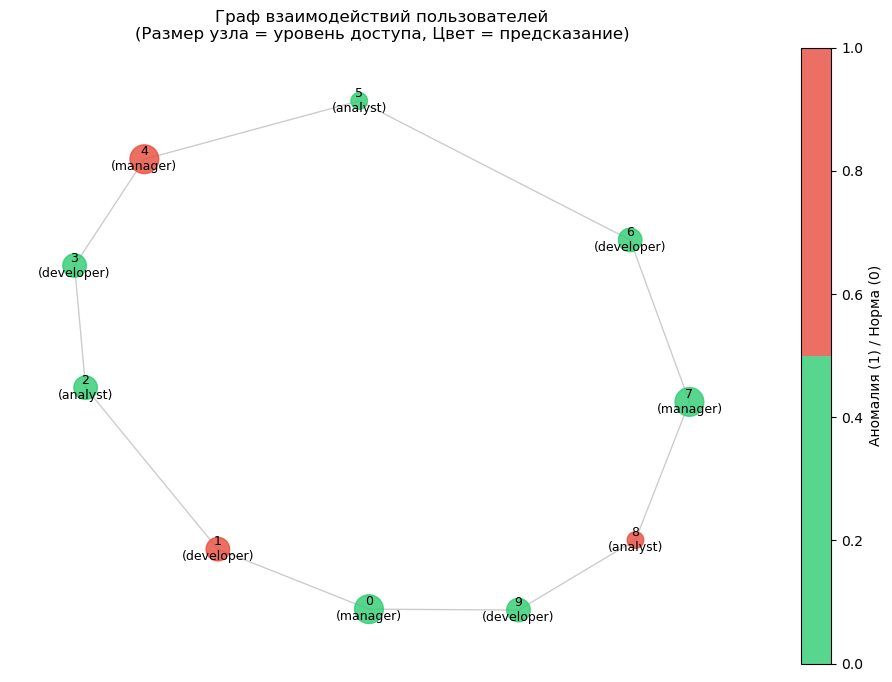

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Загрузка CSV
nodes = pd.read_csv('data/nodes.csv', parse_dates=['last_login_time'])
edges = pd.read_csv('data/edges.csv', parse_dates=['timestamp'])
resources = pd.read_csv('data/resources.csv')

# Преобразование времени в числовой формат (Unix-время)
edges['timestamp_unix'] = edges['timestamp'].astype(int) // 10**9
nodes['last_login_unix'] = nodes['last_login_time'].astype(int) // 10**9

# Нормализация признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
node_features = scaler.fit_transform(nodes[['login_count', 'access_level', 'activity_time_variance']])
# Превращаем resource_features в массив признаков
#resource_features = scaler.fit_transform(resources[['access_count_last_month']])

unique_resources = sorted(set(edges['resource_id']))
resource_map = {rid: idx for idx, rid in enumerate(unique_resources)}

# Создать правильный массив признаков
#resource_features = scaler.fit_transform(resources.loc[resources['resource_id'].isin(unique_resources)])
resource_features = scaler.fit_transform(resources[['access_count_last_month']])

# Создание тензоров
node_features = torch.tensor(node_features, dtype=torch.float)
resource_features = torch.tensor(resource_features, dtype=torch.float)
edge_index = torch.tensor([edges['source'].values, edges['target'].values], dtype=torch.long)

#edge_attr = torch.tensor(edges[['weight', 'timestamp_unix']].values, dtype=torch.float)

# Теперь добавляем признак ресурса в каждое ребро, соответствующее этому ресурсу
edge_attr = []
for idx, row in edges.iterrows():
    res_idx = resource_map.get(row['resource_id'], None)
    if res_idx is not None:
        feature_value = float(resource_features[res_idx])
        original_attrs = [row['weight'], row['timestamp_unix']]
        new_attrs = original_attrs + [feature_value]
        edge_attr.append(new_attrs)

# Пример меток (замените на реальные данные)
labels = torch.tensor([0] * len(node_features), dtype=torch.long)  # Все узлы пока "нормальные"


# Создаем пример данных

#node_features = torch.randn(10, 3)  # 10 пользователей, 3 признака
#edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#                          [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]], dtype=torch.long)
#edge_attr = torch.randn(10, 2)  # 10 ребер, 2 признака (weight и timestamp_unix)
labels = torch.tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=torch.long)  # Метки для 10 узлов

# Приводим к нужному формату
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr_tensor, y=labels)
loader = DataLoader([data], batch_size=1)

class HybridModel(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim):
        super().__init__()
        # GCN часть
        self.gcn1 = GCNConv(num_node_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

        # LSTM для обработки временных меток
        self.lstm = nn.LSTM(input_size=num_edge_features+1,  # +1 потому что добавлен один признак ресурса
                           hidden_size=hidden_dim,
                           batch_first=True)
        # Классификатор
        self.fc = nn.Linear(hidden_dim * 2, 2)  # Умножаем на 2, так как объединяем GCN и LSTM выходы

    def forward(self, data):
        # Обработка графа
        x = F.relu(self.gcn1(data.x, data.edge_index))
        x_gcn = self.gcn2(x, data.edge_index)  # [num_nodes, hidden_dim]

        # Обработка временных признаков
        edge_attr = data.edge_attr.unsqueeze(0)  # [1, num_edges, num_edge_features]
        _, (h_n, _) = self.lstm(edge_attr)
        lstm_out = h_n.squeeze(0)  # [1, hidden_dim]

        # Применяем GCN признаки к каждому узлу
        gcn_out = x_gcn  # [num_nodes, hidden_dim]

        # Повторяем LSTM выход для каждого узла
        lstm_repeated = lstm_out.repeat(gcn_out.size(0), 1)  # [num_nodes, hidden_dim]

        # Объединение признаков
        combined = torch.cat([gcn_out, lstm_repeated], dim=1)  # [num_nodes, hidden_dim * 2]

        return F.log_softmax(self.fc(combined), dim=1)

# Инициализация модели
model = HybridModel(
    num_node_features=3,  # login_count, access_level, activity_time_variance
    num_edge_features=2,  # weight и timestamp_unix
    hidden_dim=64
)

# Обучение
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)  # [num_nodes, 2]
        loss = criterion(out, batch.y)  # Сравниваем с [num_nodes]
        loss.backward()
        optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Проверка предсказаний
model.eval()
with torch.no_grad():
    out = model(data)
    predictions = out.argmax(dim=1)
    print("Predictions:", predictions)

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap

def visualize_graph(data, predictions, node_roles):
    G = nx.Graph()

    # Добавляем узлы с атрибутами
    for i in range(len(data.x)):
        G.add_node(i,
                  role=node_roles[i],  # Используем переданный список ролей
                  pred=int(predictions[i]),
                  conf=float(torch.exp(out[i]).max()))

    # Добавляем рёбра с весами
    for src, dst in data.edge_index.t().numpy():
        G.add_edge(src, dst, weight=float(data.edge_attr[src][0]))

    # Цвета узлов
    cmap = ListedColormap(['#2ecc71', '#e74c3c'])  # Зелёный=норма, Красный=аномалия
    node_colors = [G.nodes[n]['pred'] for n in G.nodes]

    # Размеры узлов по уровню доступа
    node_sizes = [300 + 100*data.x[i][1].item() for i in G.nodes]  # access_level

    # Позиции узлов
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    # Рисуем рёбра
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)

    # Рисуем узлы
    nodes_draw = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        node_size=node_sizes,
        alpha=0.8
    )

    # Подписи узлов
    labels = {n: f"{n}\n({G.nodes[n]['role']})" for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)

    # Легенда
    plt.colorbar(nodes_draw, label="Аномалия (1) / Норма (0)")
    plt.title("Граф взаимодействий пользователей\n(Размер узла = уровень доступа, Цвет = предсказание)")
    plt.axis('off')
    plt.show()

# Список ролей пользователей
node_roles = ['manager', 'developer', 'analyst', 'developer', 'manager',
              'analyst', 'developer', 'manager', 'analyst', 'developer']

# Вызов функции визуализации
visualize_graph(data, predictions, node_roles)
